In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 6
commitnumber = d62b618
conc = 1.8e-06
dv = 0.005
klin = 0
molecule = ch4
ng_adju = [0, 0]
ng_refs = [2, 4]
nv = 200
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 294
vmax = 1215
vmin = 1100
w_diffuse = [(1.66, 1.66), (1.66, 1.66, 1.66, 1.66)]
wgt = [(1, 1), (1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

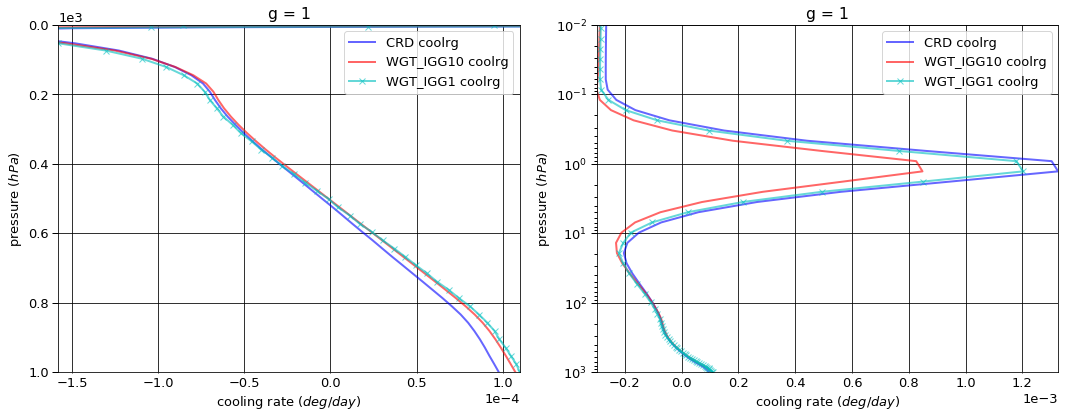

# Figure: cooling rate g-group 2

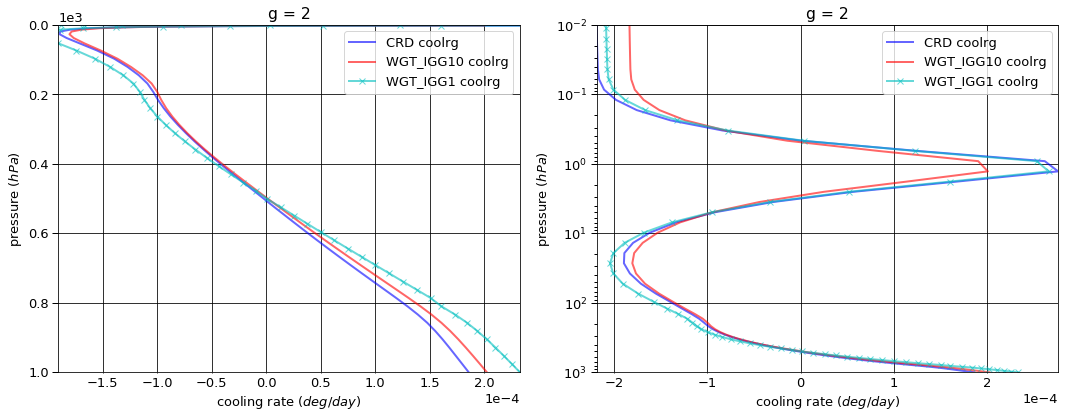

# Figure: cooling rate g-group 3

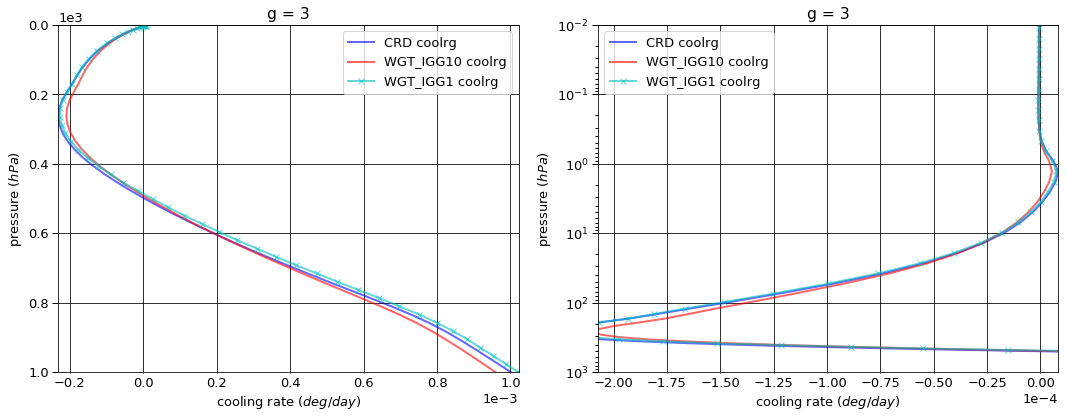

# Figure: cooling rate g-group 4

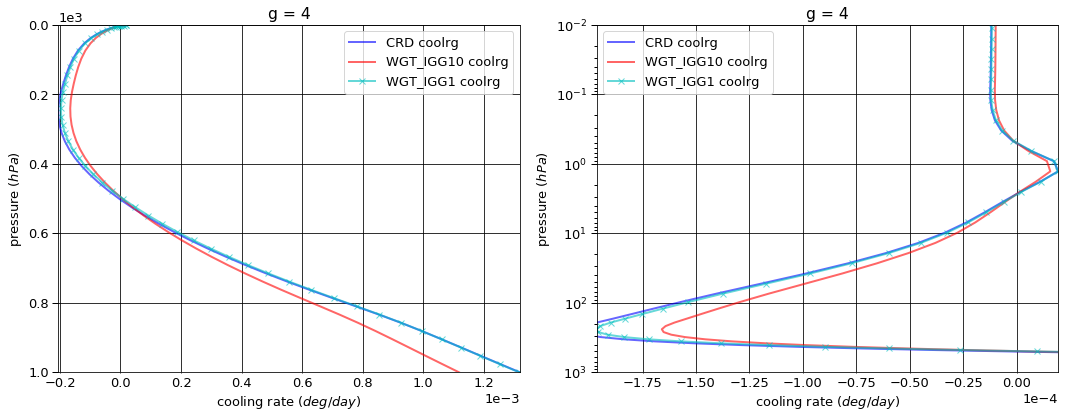

# Figure: cooling rate g-group 5

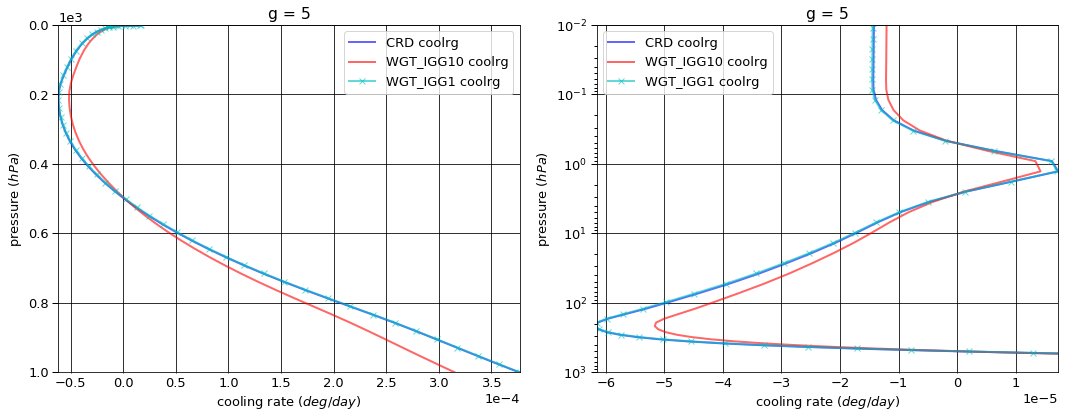

# Figure: cooling rate g-group 6

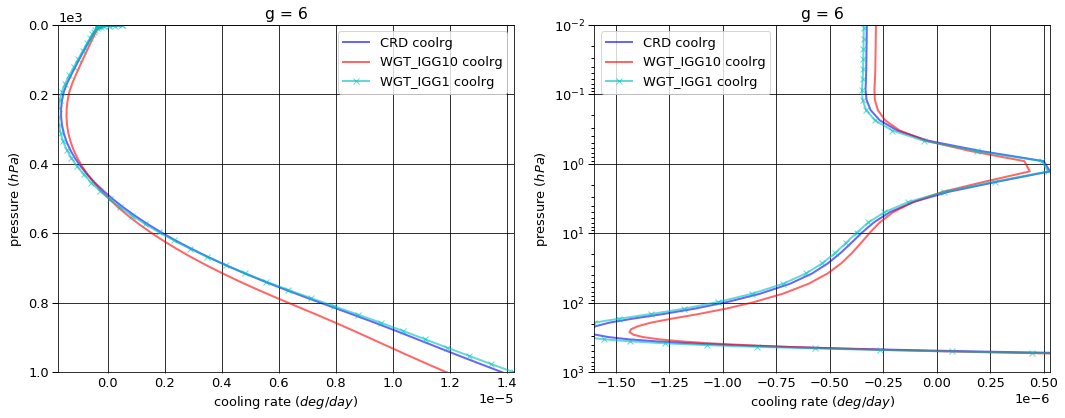

# Figure: cooling rate g-group total

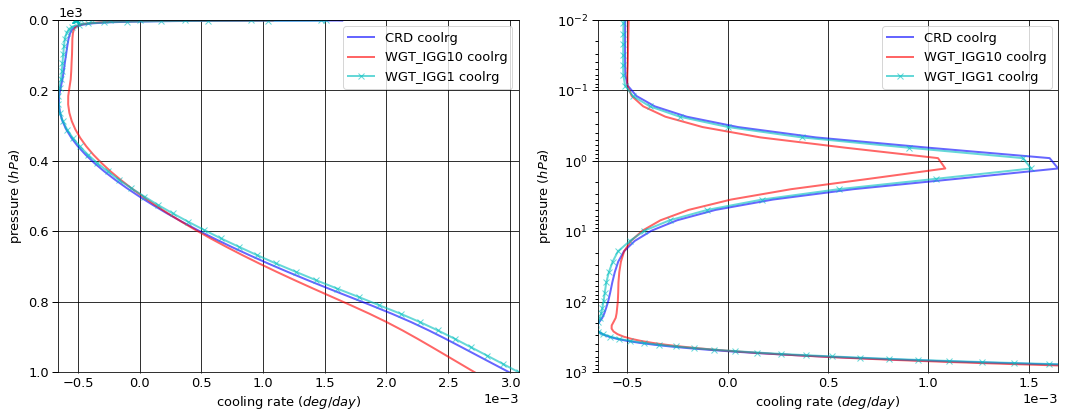

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.034948  0.000000  -0.034948
  1013.0   76     -0.043001  0.007618  -0.035382
2 0.0      1      -0.435404  0.000000  -0.435404
  1013.0   76     -0.446767  0.012263  -0.434504
3 0.0      1      -0.435754  0.000000  -0.435754
  1013.0   76     -0.466891  0.054540  -0.412351
4 0.0      1      -4.638270  0.000000  -4.638270
  1013.0   76     -4.666739  0.057933  -4.608805
5 0.0      1     -12.751396  0.000000 -12.751396
  1013.0   76    -12.759368  0.016093 -12.743275
6 0.0      1      -4.886655  0.000000  -4.886655
  1013.0   76     -4.886894  0.000567  -4.886327


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.033268  0.000000  -0.033268
  1013.0   76     -0.041399  0.007920  -0.033479
2 0.0      1      -0.429977  0.000000  -0.429977
  1013.0   76     -0.440684  0.012409  -0.428275
3 0.0      1      -0.420838  0.000000  -0.420838
  1013.0   76     -0.447992  0.050293  -0.397700
4 0.0      1      -4.527648  0.000000  -4.527648
  1013.0   76     -4.550716  0.048655  -4.502061
5 0.0      1     -12.750614  0.000000 -12.750614
  1013.0   76    -12.757229  0.013451 -12.743778
6 0.0      1      -5.031431  0.000000  -5.031431
  1013.0   76     -5.031639  0.000483  -5.031156


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.032850  0.000000  -0.032850
  1013.0   76     -0.041399  0.008410  -0.032990
2 0.0      1      -0.428218  0.000000  -0.428218
  1013.0   76     -0.440684  0.014426  -0.426258
3 0.0      1      -0.417498  0.000000  -0.417498
  1013.0   76     -0.447992  0.055584  -0.392408
4 0.0      1      -4.523265  0.000000  -4.523265
  1013.0   76     -4.550716  0.057715  -4.493001
5 0.0      1     -12.749305  0.000000 -12.749305
  1013.0   76    -12.757229  0.016109 -12.741121
6 0.0      1      -5.031389  0.000000  -5.031389
  1013.0   76     -5.031639  0.000579  -5.031061


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001680  0.000000  0.001680
  1013.0   76     0.001601  0.000302  0.001903
2 0.0      1      0.005427  0.000000  0.005427
  1013.0   76     0.006083  0.000145  0.006229
3 0.0      1      0.014916  0.000000  0.014916
  1013.0   76     0.018898 -0.004247  0.014651
4 0.0      1      0.110622  0.000000  0.110622
  1013.0   76     0.116023 -0.009279  0.106745
5 0.0      1      0.000782  0.000000  0.000782
  1013.0   76     0.002139 -0.002642 -0.000503
6 0.0      1     -0.144776  0.000000 -0.144776
  1013.0   76    -0.144745 -0.000084 -0.144829


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.002098  0.000000  0.002098
  1013.0   76     0.001601  0.000791  0.002393
2 0.0      1      0.007187  0.000000  0.007187
  1013.0   76     0.006083  0.002163  0.008246
3 0.0      1      0.018256  0.000000  0.018256
  1013.0   76     0.018898  0.001045  0.019943
4 0.0      1      0.115005  0.000000  0.115005
  1013.0   76     0.116023 -0.000218  0.115805
5 0.0      1      0.002091  0.000000  0.002091
  1013.0   76     0.002139  0.000016  0.002154
6 0.0      1     -0.144734  0.000000 -0.144734
  1013.0   76    -0.144745  0.000012 -0.144733

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.578702e-04
  1001.112500 75     9.772716e-05
2 0.000312    1     -2.201530e-04
  1001.112500 75     1.858776e-04
3 0.000312    1     -7.241088e-07
  1001.112500 75     1.001989e-03
4 0.000312    1     -1.153976e-05
  1001.112500 75     1.319021e-03
5 0.000312    1     -1.401294e-05
  1001.112500 75     3.764159e-04
6 0.000312    1     -3.214702e-07
  1001.112500 75     1.382873e-05


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -2.742571e-04
  1001.112500 75     1.073488e-04
2 0.000312    1     -1.842394e-04
  1001.112500 75     2.025625e-04
3 0.000312    1     -6.235503e-07
  1001.112500 75     9.597458e-04
4 0.000312    1     -9.558789e-06
  1001.112500 75     1.118113e-03
5 0.000312    1     -1.189208e-05
  1001.112500 75     3.151610e-04
6 0.000312    1     -2.787812e-07
  1001.112500 75     1.187496e-05


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -2.745682e-04
  1001.112500 75     1.098913e-04
2 0.000312    1     -2.100200e-04
  1001.112500 75     2.327488e-04
3 0.000312    1     -6.815407e-07
  1001.112500 75     1.022113e-03
4 0.000312    1     -1.133536e-05
  1001.112500 75     1.316477e-03
5 0.000312    1     -1.424061e-05
  1001.112500 75     3.771612e-04
6 0.000312    1     -3.341748e-07
  1001.112500 75     1.423341e-05


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.638686e-05
  1001.112500 75     9.621679e-06
2 0.000312    1      3.591364e-05
  1001.112500 75     1.668487e-05
3 0.000312    1      1.005585e-07
  1001.112500 75    -4.224355e-05
4 0.000312    1      1.980973e-06
  1001.112500 75    -2.009082e-04
5 0.000312    1      2.120856e-06
  1001.112500 75    -6.125493e-05
6 0.000312    1      4.268898e-08
  1001.112500 75    -1.953772e-06


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.669804e-05
  1001.112500 75     1.216412e-05
2 0.000312    1      1.013298e-05
  1001.112500 75     4.687116e-05
3 0.000312    1      4.256815e-08
  1001.112500 75     2.012390e-05
4 0.000312    1      2.044030e-07
  1001.112500 75    -2.544500e-06
5 0.000312    1     -2.276740e-07
  1001.112500 75     7.453500e-07
6 0.000312    1     -1.270462e-08
  1001.112500 75     4.046840e-07

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.182427,0.000000,-23.182427
1013.0,76,-23.269659,0.149015,-23.120645



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.193776,0.00000,-23.193776
1013.0,76,-23.269659,0.13321,-23.136449



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.182525,0.000000,-23.182525
1013.0,76,-23.269659,0.152823,-23.116837



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.134838e-02,0.000000,-0.011348
1013.0,76,1.310000e-07,-0.015804,-0.015804



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-9.787500e-05,0.000000,-0.000098
1013.0,76,1.310000e-07,0.003808,0.003807


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000505
1001.112500,75,0.002995



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000481
1001.112500,75,0.002715



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000511
1001.112500,75,0.003073



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000024
1001.112500,75,-0.000280



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000007
1001.112500,75,0.000078


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.002043,0.001779
2,0.019913,0.018938
3,0.022391,0.019252
4,0.214348,0.195564
5,0.547870,0.548234
6,0.193435,0.216232


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.000576e-20
2,3.469895e-22
3,9.290698e-22
4,5.931843e-23
5,3.787311e-24
6,2.418089e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.000576e-20,NaN,0.002043,0.001779,0.002043,0.001779,1.0
2,3.469895e-22,0.034679,0.019913,0.018938,0.021957,0.020717,1.0
3,9.290698e-22,2.677516,0.022391,0.019252,0.044348,0.039969,500.0
4,5.931843e-23,0.063847,0.214348,0.195564,0.258696,0.235534,500.0
5,3.787311e-24,0.063847,0.547870,0.548234,0.806565,0.783768,500.0
6,2.418089e-25,0.063847,0.193435,0.216232,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
